<a href="https://www.kaggle.com/code/averma111/pytorch-cnn-basics?scriptVersionId=128980176" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [17]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [3]:
test_data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/'
train_data_dir ='/kaggle/input/intel-image-classification/seg_train/seg_train/'

In [5]:
train_dataset = ImageFolder(train_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [7]:
image,label = train_dataset[0]

print(image.shape,label)

torch.Size([3, 150, 150]) 0


In [9]:
print("Follwing classes are there : \n",train_dataset.classes)

Follwing classes are there : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


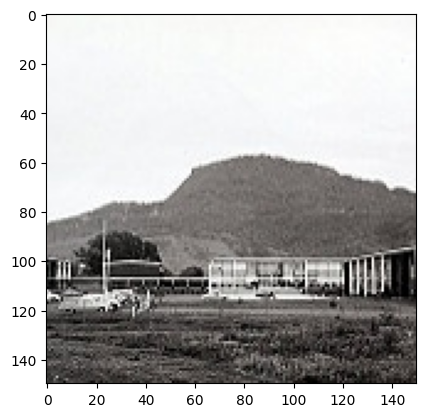

In [13]:
def display_image(image,label):
     plt.imshow(image.permute(1,2,0))

display_image(*train_dataset[0])

In [15]:
BATCH_SIZE = 128
test_size = 2000
train_size = len(train_dataset) - test_size

In [16]:
train_data,test_data = random_split(train_dataset,[train_size,test_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(test_data)}")

Length of Train Data : 12034
Length of Validation Data : 2000


In [22]:
train_dataloader = DataLoader(train_data,BATCH_SIZE,shuffle=True,num_workers = 4, pin_memory = True)
test_dataloader = DataLoader(test_data,BATCH_SIZE,num_workers = 4, pin_memory = True)

In [23]:
def show_batch_images(dataloader):
    for images,labels in dataloader:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

In [24]:
show_batch_images(train_dataloader)

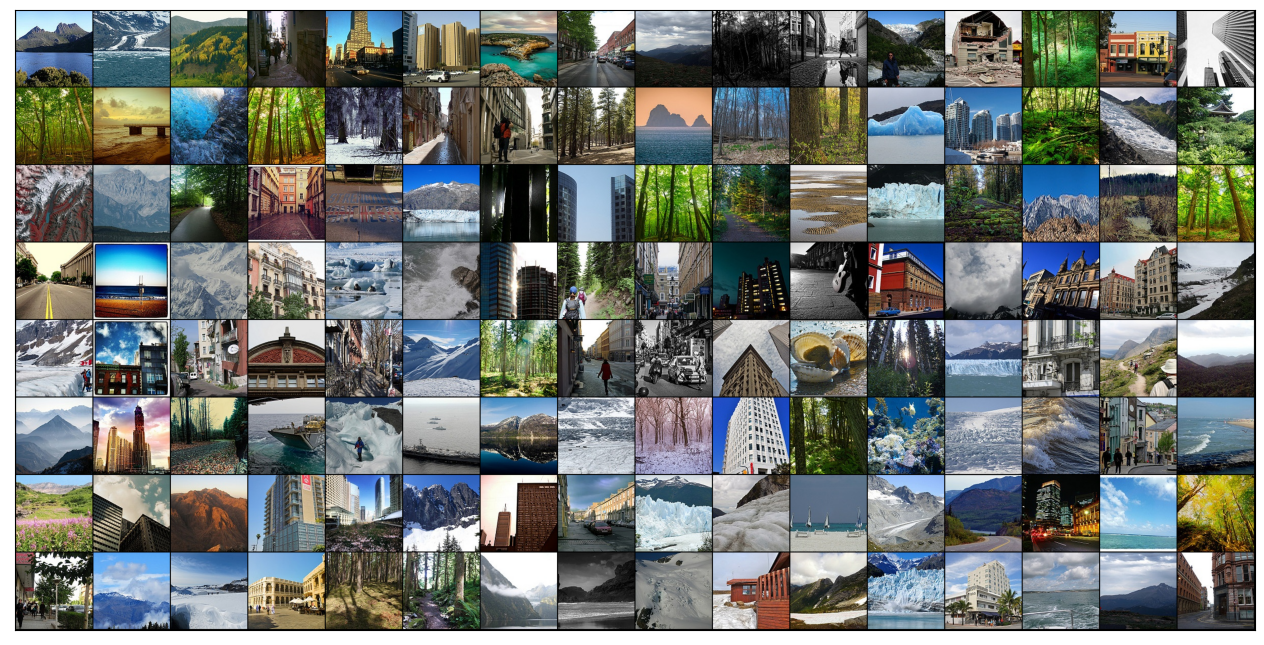

In [25]:
show_batch_images(test_dataloader)

In [38]:
import torch.nn.functional as F
class ImageClassificationBase(torch.nn.Module):
    
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['test_loss'], result['test_acc']))

In [39]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            
            torch.nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
        
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            torch.nn.Flatten(),
            torch.nn.Linear(82944,1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
           torch. nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [40]:
model = NaturalSceneClassification()
print(model)

NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [41]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [42]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dataloader, test_dataloader, opt_func)

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)